In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import os
from tensorflow.keras import utils

# 進度條模組
from tqdm import tqdm
%matplotlib inline

In [2]:
#檢測tensorflow gpu是否啟用
tf.config.list_physical_devices("GPU")
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
# 8種類
class_names = ['normal' , 'error_ear' , 'error_iron' , 'error_solder' , 'noearing' , 'noiron' , 'NG']

# 只挑選5類實驗
# class_names = ['normal'  , 'error_iron' , 'error_ear' , 'noiron' , 'noearing']

class_names_label = {class_name:i for i,class_name in enumerate(class_names)}
print(class_names_label)

nb_classes = len(class_names)

IMAGE_SIZE = (70 , 120)

{'normal': 0, 'error_ear': 1, 'error_iron': 2, 'error_solder': 3, 'noearing': 4, 'noiron': 5, 'NG': 6}


In [4]:
def to_grayscale(image):
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Val_datagen = ImageDataGenerator(rescale = 1/255
                                ,preprocessing_function = to_grayscale)


Batch_Size = 8

test_generator = Val_datagen.flow_from_directory('E://mask_data//20211224_data//test',#类别子文件夹的上一级文件夹
                                    batch_size=Batch_Size,
                                    shuffle=True,
                                    target_size=IMAGE_SIZE,
                                    )

print(test_generator.n)

Found 2399 images belonging to 7 classes.
2399


In [6]:
pred_path = 'E://mask_data//20211224_data//test//'
pred_data = list(test_generator.class_indices.keys())
print(pred_data)

class_names = pred_data


fp_count = 0
labels = []
images = []
pred_labels = []
y_predictions_All = []
file_count = 0
for pred_dir_name in pred_data:
    pred_file_path = pred_path+pred_dir_name
    pred_file_list = os.listdir(pred_file_path)
    for file_name in pred_file_list:
        file_count = file_count+1
        image = cv2.imread(pred_file_path+'/'+file_name)
        image = np.array(image)
        image = cv2.resize(image,(120 , 70))
        image = image/255
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.grayscale_to_rgb(image)
        
#         for model in model_file:
#             model = tf.keras.models.load_model('20220208_(70_120)_model_acc_loss_pic_B0-B7//'+model)
#             predictions = model.predict(test_generator)
#             pred_labels = np.argmax(predictions, axis = 1) 
#             pred_labels = np.array(pred_labels,dtype = 'int32')
#             y_predictions_All.append(pred_labels)
        images.append(image)
        labels.append(pred_data.index(pred_dir_name))
        for_pred_labels = utils.to_categorical(labels , nb_classes , dtype = 'int32')

['NG', 'error_ear', 'error_iron', 'error_solder', 'noearing', 'noiron', 'normal']


In [7]:
images = np.array(images , dtype = 'float32')
labels = np.array(labels , dtype = 'int32')

In [8]:
for_pred_labels

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [9]:
filepath = '20220208_(70_120)_model_acc_loss_pic_B0-B7//Mask_AOI-EfficientNetB0_0119_1_g.h5'
model = tf.keras.models.load_model(filepath)

results = model.evaluate(images, for_pred_labels, batch_size=128)
print("test loss, test acc:", results)

19/19 [==============================] - 5s 91ms/step - loss: 0.9756 - accuracy: 0.8353
test loss, test acc: [0.9755871295928955, 0.8353480696678162]


In [10]:
predictions = model.predict(images)     
pred_labels = np.argmax(predictions, axis = 1) 
pred_labels = np.array(pred_labels,dtype = 'int32')
pred_labels

array([0, 0, 0, ..., 2, 6, 6])

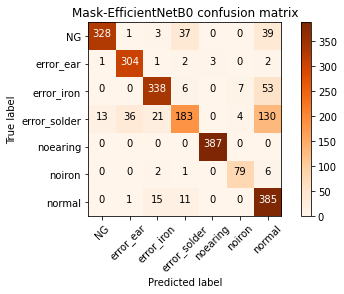

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title='Mask-EfficientNetB0 confusion matrix'

    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.savefig('E://Mask_confusion//Mask-EvolvedB0.jpg')
    plt.show()


confusion_mtx = confusion_matrix(labels, pred_labels)
plot_confusion_matrix(confusion_mtx, classes = class_names)